# fusion_analysis_d23a
BSG, 2023

In [1]:
import d23a
import datetime
import matplotlib.pyplot as plt

In [2]:
# Get start datetime
start_dt = datetime.datetime.now()

## Figures for manuscript

Written fig01.pdf (0.04 MB)
Written fig01.png (0.62 MB)


'fig01'

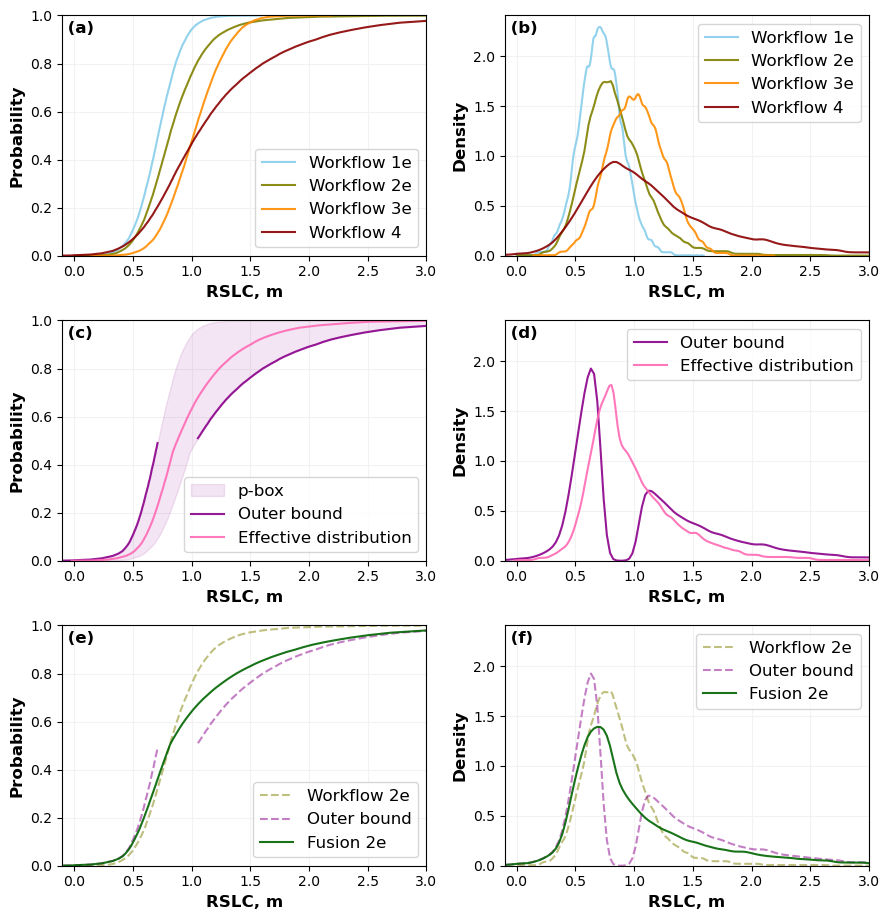

In [3]:
# SSP5 year-2100 AR6 projections, p-box, and fusion
fig, axs = d23a.fig_qfs_marginals(workflows_r=(('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), ('outer', 'effective_0.5'), ('fusion_2e',)),
                                  bg_workflows_r=(list(), list(), ('wf_2e', 'outer')),
                                  pbox_r=(False, True, False),
                                  rate=False, scenario='ssp585', year=2100, gauge='TANJONG_PAGAR', xlim=(-0.1, 3.))
d23a.name_save_fig(fig)

Written fig02.pdf (0.03 MB)
Written fig02.png (0.14 MB)


'fig02'

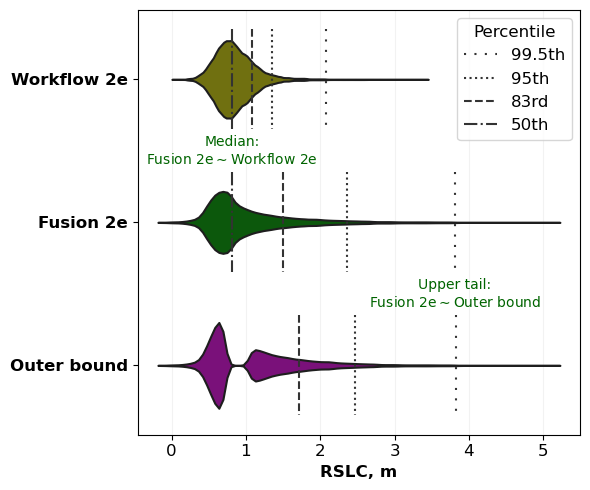

In [4]:
# SSP5 year-2100 violinplot
fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)
ax = d23a.plot_rslc_violinplot(workflows=('wf_2e', 'fusion_2e', 'outer'),
                               rate=False, scenario='ssp585', year=2100, gauge='TANJONG_PAGAR', annotations=True, ax=ax)
d23a.name_save_fig(fig)

Written fig03.pdf (0.02 MB)
Written fig03.png (0.21 MB)


'fig03'

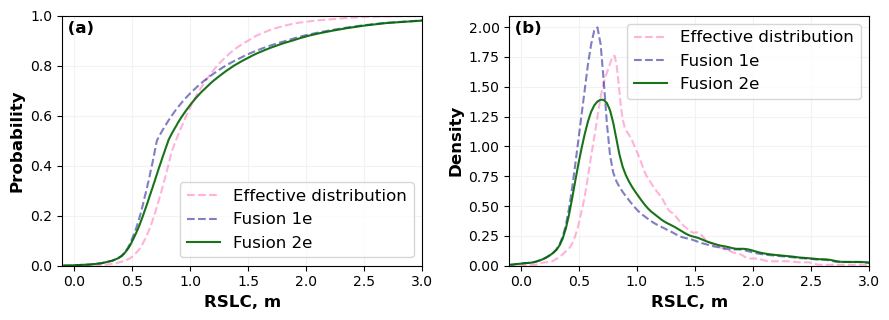

In [5]:
# SSP5 year-2100 effective_0.5, fusion_1e, fusion_2e
fig, axs = d23a.fig_qfs_marginals(workflows_r=(('fusion_2e',),),
                                  bg_workflows_r=(('effective_0.5', 'fusion_1e'),),
                                  pbox_r=(False,),
                                  rate=False, scenario='ssp585', year=2100, gauge='TANJONG_PAGAR', xlim=(-0.1, 3.))
d23a.name_save_fig(fig)

Written fig04.pdf (0.02 MB)
Written fig04.png (0.10 MB)


'fig04'

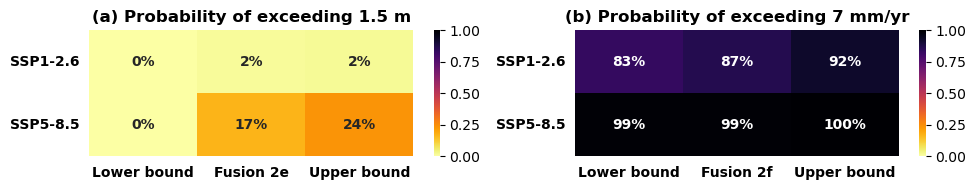

In [6]:
# SSP5 vs SSP1 heatmap tables for probability of exceeding (a) 1.5 m and (b) 7 mm/yr
fig, axs = plt.subplots(1, 2, figsize=(10, 2), tight_layout=True)
# (a) 1.5 m
ax = axs[0]
_ = d23a.plot_exceedance_heatmap(threshold=1.5, workflows=('lower', 'fusion_2e', 'upper'), rate=False,
                                 scenarios=('ssp126', 'ssp585'), year=2100, gauge='TANJONG_PAGAR', ax=ax)
ax.set_title('(a) Probability of exceeding 1.5 m')
# (a) 7 mm/yr
ax = axs[1]
_ = d23a.plot_exceedance_heatmap(threshold=1.5, workflows=('lower', 'fusion_2f', 'upper'), rate=True,
                                 scenarios=('ssp126', 'ssp585'), year=2100, gauge='TANJONG_PAGAR', ax=ax)
ax.set_title('(b) Probability of exceeding 7 mm/yr')
# Save
d23a.name_save_fig(fig)

## Other figures

Written o01.pdf (0.03 MB)
Written o01.png (0.35 MB)


'o01'

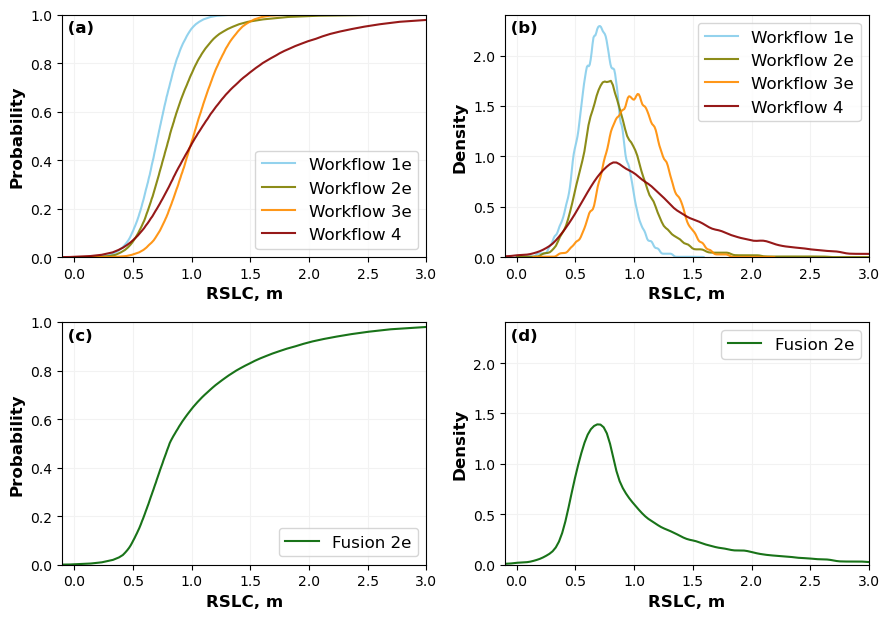

In [7]:
# SSP5 year-2100 AR6 projections and fusion
fig, axs = d23a.fig_qfs_marginals(workflows_r=(('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), ('fusion_2e',)),
                                  bg_workflows_r=(list(), list()),
                                  pbox_r=(False, False),
                                  rate=False, scenario='ssp585', year=2100, gauge='TANJONG_PAGAR', xlim=(-0.1, 3.))
d23a.name_save_fig(fig, fso='o')

## Watermark and timing info

In [8]:
print(d23a.get_watermark())

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.13.2

matplotlib: 3.7.1
numpy     : 1.24.3
pandas    : 2.0.2
seaborn   : 0.12.2
xarray    : 2023.5.0

conda environment: d23a-fusion

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit


In [9]:
# Get end datetime
end_dt = datetime.datetime.now()
# Calculate run timedelta
run_td = end_dt - start_dt
# Print timing information
print(f"Start:     {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End:       {end_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Wall time: {run_td.seconds} s")

Start:     2023-10-03 16:30:48
End:       2023-10-03 16:31:14
Wall time: 26 s
